# RNN on Time series dataset

On this Notebook we will build a recurrent model on a multi-variate time series dataset.

## The data

The dataset is a multi-variate time series. Let's do a very short EDA on it:

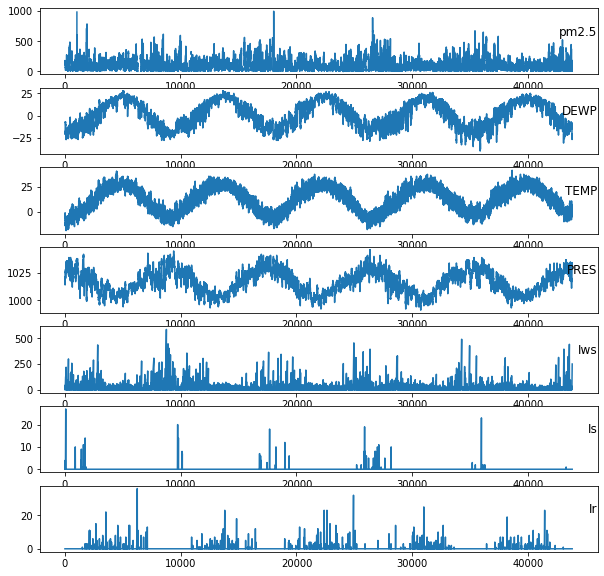

In [14]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset_path = '/home/fer/data/formaciones/master/deep-learning-intro/datasets/time_series/pollution.csv'
dataset = pd.read_csv(dataset_path,  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)


values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
plt.figure(figsize=(10,10))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [15]:

# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'

# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
dataset.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


This is what we have. It should be necessary to spend more time on reviewing it, but we will focus on the RNN application. Let's first get rid of the categorical feature by using a label encoder (not the best solution for sure) and scale the now continuous features.

<font color=red><b>Scale the dataset
<br>Hint: use the minmaxscaler function </b>
</font>

In [16]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
values = values.astype('float32')
...

Ellipsis

The next function converts our series data into a supervised learning one, by shifting it and adding timesteps to each row:

In [27]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg



# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,0.213115,0.563637,0.666667,0.011433,0.111111,0.0


This way, in our example, we have the feature values for the current timestep and the previous. The idea is to predict the next from the current. So we are interested in predicting $var1(t)$ from $var1(t-1), var2(t-1), \cdots, var8(t-1)$. Let's drop the useless features:

In [28]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658


Let's divide it now in traiing and testing. In order to do that, we can leave the last year as testing.

<font color=red><b>Split the data
</font>

In [ ]:
# split into train and test sets
values = reframed.values
...
train = ...
test = ...
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

Please note the dataset shape: (N_samples, timesteps, n_features). 

## Model Architecture:
We will build now an LSTM network in order to predict the target.


- Use a LSTM layer, with 50 units.
- Use a dense layer with a single feature: the one we are trying to predict.
- Compile it using mae as the loss and adam as the optimizer.
- train it using the test data as validation, not shuffling the data (why?) and using 10 epochs and a batch size of 72.
- Store the fitting inside a history variable, for plotting purposes.


<font color=red><b>Build the model
</font>

In [ ]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
# design network
...
# fit network
history = ...

Now let's plot the loss. We have a few epochs, but we can see the prgress:

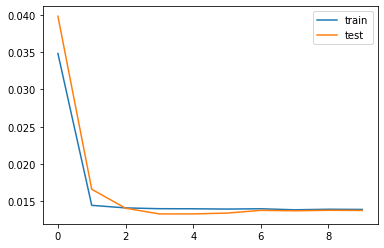

In [31]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Finally, let's see how well we did. Keep in mind that the model does predict at scaled level. So we need to de-escalate:

In [36]:
import numpy as np
# make a prediction
yhat = model.predict(test_X)
x_test = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, x_test[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
y_test = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((y_test, x_test[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]



<font color=red><b>Compute the rmse and mae at test level
</font>

In [ ]:
from sklearn.metrics import ...
from math import sqrt
# calculate RMSE
rmse = ... 
mae = ...
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

And finally, let's plot the first 100 results:

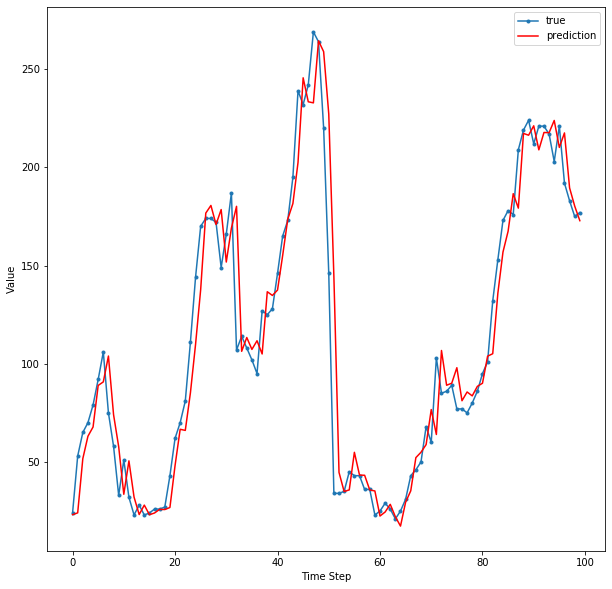

In [40]:

plt.figure(figsize=(10,10))
plt.plot(inv_y[0:100], marker='.', label="true")
plt.plot(inv_yhat[0:100], 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()